In [1]:
import os
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv

# Load environment variables
load_dotenv("../.env")  
client = MongoClient(os.getenv("MONGODB_CONNECTION_STRING"))
db = client["cricket_elo"]
player_ratings_collection = db["player_ratings"]

def get_top_n_players(n=10):
    """Fetches the top N players based on their latest Elo rating."""
    players = list(player_ratings_collection.find({}, {"_id": 0, "player_name": 1, "batting_rating": 1, "bowling_rating": 1}))

    latest_batting_ratings = []
    latest_bowling_ratings = []
    
    for player in players:
        player_name = player["player_name"]
        
        # Process Batting Rating
        if player.get("batting_rating"):
            batting_df = pd.DataFrame(player["batting_rating"])
            if not batting_df.empty:
                latest_entry = batting_df.loc[batting_df["date"].idxmax()]  # Get latest match rating
                latest_batting_ratings.append({
                    "player_name": player_name,
                    "batting_rating": latest_entry["rating"],
                    "n_entries": len(batting_df)
                })

        # Process Bowling Rating
        if player.get("bowling_rating"):
            bowling_df = pd.DataFrame(player["bowling_rating"])
            if not bowling_df.empty:
                latest_entry = bowling_df.loc[bowling_df["date"].idxmax()]  # Get latest match rating
                latest_bowling_ratings.append({
                    "player_name": player_name,
                    "bowling_rating": latest_entry["rating"],
                    "n_entries": len(bowling_df)
                })

    # Convert lists to DataFrames
    df_batting = pd.DataFrame(latest_batting_ratings)
    df_bowling = pd.DataFrame(latest_bowling_ratings)

    # Filter out default ratings (1000) and players with fewer than 20 matches
    top_batters = (
        df_batting
        .loc[(df_batting["batting_rating"] != 1200) & (df_batting["n_entries"] > 1)]
        .nlargest(n, "batting_rating")[["player_name", "batting_rating"]]
        .reset_index(drop=True)
    )

    top_bowlers = (
        df_bowling
        .loc[(df_bowling["bowling_rating"] != 1200) & (df_bowling["n_entries"] > 1)]
        .nlargest(n, "bowling_rating")[["player_name", "bowling_rating"]]
        .reset_index(drop=True)
    )

    # Merge both DataFrames for an overall ranking
    df_combined = pd.merge(df_batting, df_bowling, on="player_name", how="outer")

    df_combined["allrounder_rating"] = 2 * (df_combined["batting_rating"] * df_combined["bowling_rating"]) / (df_combined["batting_rating"] + df_combined["bowling_rating"])
    
    top_allrounders = (
        df_combined
        .loc[(df_combined["allrounder_rating"] != 1200)]
        .nlargest(n, "allrounder_rating")[["player_name", "allrounder_rating"]]
        .reset_index(drop=True)
    )

    # Adjust index to start from 1
    top_batters.index += 1
    top_bowlers.index += 1
    top_allrounders.index += 1

    return top_batters, top_bowlers, top_allrounders, df_combined

# Fetch and display top players
n = 10
top_batters, top_bowlers, top_allrounders, df = get_top_n_players(n)
print(f"Top {n} Batters:\n", top_batters)
print(f"\nTop {n} Bowlers:\n", top_bowlers)
print(f"\nTop {n} All-rounders:\n", top_allrounders)

Top 10 Batters:
         player_name  batting_rating
1          MS Dhoni     1383.591706
2          T Stubbs     1382.343962
3        RM Patidar     1382.240970
4          N Pooran     1379.987550
5          SA Yadav     1379.825960
6           PD Salt     1375.732821
7         SP Narine     1374.479278
8   J Fraser-McGurk     1372.966498
9   Abhishek Sharma     1371.688516
10  B Sai Sudharsan     1371.466107

Top 10 Bowlers:
       player_name  bowling_rating
1       SP Narine     1407.330661
2        CV Varun     1404.592769
3      MJ Santner     1393.414494
4    M Theekshana     1392.430157
5       PP Chawla     1389.580676
6        R Ashwin     1387.560401
7        AR Patel     1386.632219
8       JJ Bumrah     1386.115723
9        TA Boult     1385.700066
10  Shahbaz Ahmed     1382.644053

Top 10 All-rounders:
         player_name  allrounder_rating
1         SP Narine        1390.710993
2           C Green        1374.148847
3         RA Jadeja        1369.202392
4   Abhishek Sha

<Axes: ylabel='Frequency'>

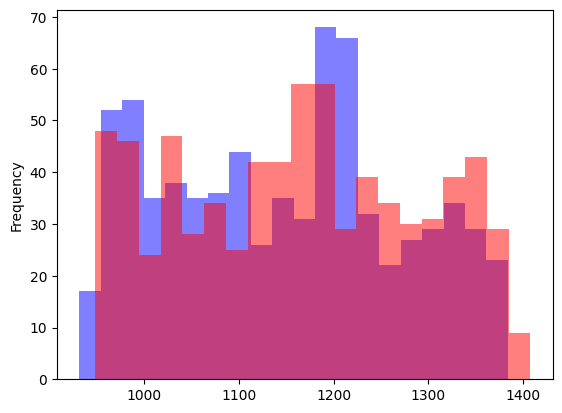

In [2]:
df['batting_rating'].plot.hist(bins=20, alpha=0.5, color='blue', label='Batting Ratings')
df['bowling_rating'].plot.hist(bins=20, alpha=0.5, color='red', label='Bowling Ratings')

<Axes: title={'center': 'JJ Bumrah Batting Ratings'}, xlabel='Innings', ylabel='Rating'>

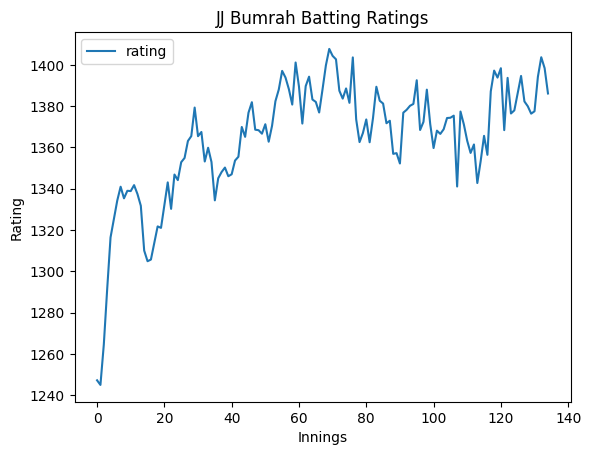

In [3]:
import matplotlib.pyplot as plt

data = 'bowling'
player = 'JJ Bumrah'

player_ratings = player_ratings_collection.find_one({"player_name": player}, {"_id": 0, "player_name": 1, f"{data}_rating": 1})
df_player = pd.DataFrame(player_ratings[f"{data}_rating"])
df_player["date"] = pd.to_datetime(df_player["date"])
df_player.plot(y='rating', title=f'{player} Batting Ratings', xlabel='Innings', ylabel='Rating')

In [4]:
import os
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv

# Load environment variables
load_dotenv("../.env")  
client = MongoClient(os.getenv("MONGODB_CONNECTION_STRING"))
db = client["cricket_elo"]
player_ratings_collection = db["player_ratings"]

def top_n_peak_rating(n=10):
    """Fetches the top N players based on their latest Elo rating."""
    players = list(player_ratings_collection.find({}, {"_id": 0, "player_name": 1, "batting_rating": 1, "bowling_rating": 1}))

    peak_batting_ratings = []
    peak_bowling_ratings = []
    
    for player in players:
        player_name = player["player_name"]
        
        # Process Batting Rating
        if player.get("batting_rating"):
            batting_df = pd.DataFrame(player["batting_rating"])
            if not batting_df.empty:
                peak_entry = batting_df.loc[batting_df["rating"].idxmax()]  # Get latest match rating
                peak_batting_ratings.append({
                    "player_name": player_name,
                    "batting_rating": peak_entry["rating"],
                    "n_entries": len(batting_df)
                })

        # Process Bowling Rating
        if player.get("bowling_rating"):
            bowling_df = pd.DataFrame(player["bowling_rating"])
            if not bowling_df.empty:
                peak_entry = bowling_df.loc[bowling_df["rating"].idxmax()]  # Get latest match rating
                peak_bowling_ratings.append({
                    "player_name": player_name,
                    "bowling_rating": peak_entry["rating"],
                    "n_entries": len(bowling_df)
                })

    # Convert lists to DataFrames
    df_batting = pd.DataFrame(peak_batting_ratings)
    df_bowling = pd.DataFrame(peak_bowling_ratings)

    # Filter out default ratings (1000) and players with fewer than 20 matches
    top_batters = (
        df_batting
        .loc[(df_batting["batting_rating"] != 1200) & (df_batting["n_entries"] > 1)]
        .nlargest(n, "batting_rating")[["player_name", "batting_rating"]]
        .reset_index(drop=True)
    )

    top_bowlers = (
        df_bowling
        .loc[(df_bowling["bowling_rating"] != 1200) & (df_bowling["n_entries"] > 1)]
        .nlargest(n, "bowling_rating")[["player_name", "bowling_rating"]]
        .reset_index(drop=True)
    )

    # Merge both DataFrames for an overall ranking
    df_combined = pd.merge(df_batting, df_bowling, on="player_name", how="outer")

    df_combined["allrounder_rating"] = 2 * (df_combined["batting_rating"] * df_combined["bowling_rating"]) / (df_combined["batting_rating"] + df_combined["bowling_rating"])
    
    top_allrounders = (
        df_combined
        .loc[(df_combined["allrounder_rating"] != 1200)]
        .nlargest(n, "allrounder_rating")[["player_name", "allrounder_rating"]]
        .reset_index(drop=True)
    )

    # Adjust index to start from 1
    top_batters.index += 1
    top_bowlers.index += 1
    top_allrounders.index += 1

    return top_batters, top_bowlers, top_allrounders, df_combined

# Fetch and display top players
n = 10
top_batters, top_bowlers, top_allrounders, df = top_n_peak_rating(n)
print(f"Top {n} Batters:\n", top_batters)
print(f"\nTop {n} Bowlers:\n", top_bowlers)
print(f"\nTop {n} All-rounders:\n", top_allrounders)

Top 10 Batters:
        player_name  batting_rating
1       AD Russell     1420.099171
2          RR Pant     1415.828421
3        HH Pandya     1415.336512
4         SA Yadav     1405.375813
5   AB de Villiers     1402.837933
6     Shubman Gill     1394.711115
7        SR Watson     1393.277098
8       JC Buttler     1392.879941
9        Q de Kock     1392.059179
10      KD Karthik     1390.831951

Top 10 Bowlers:
         player_name  bowling_rating
1       Rashid Khan     1419.358531
2         RA Jadeja     1417.411200
3         YS Chahal     1414.939411
4         RD Chahar     1414.879792
5       Imran Tahir     1412.875912
6          R Ashwin     1412.573220
7         JC Archer     1412.238753
8   Harbhajan Singh     1411.999116
9         SP Narine     1410.873127
10          S Gopal     1410.324732

Top 10 All-rounders:
     player_name  allrounder_rating
1    AD Russell        1402.406666
2     RA Jadeja        1402.079681
3     HH Pandya        1399.732216
4     SP Narine      